# ***`Projet Eco2mix`***





## `Base de données *éco2mix* et *régions*`

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 

df = pd.read_csv('eco2mix.csv', sep =';', error_bad_lines=False) 

#On met les dates en format to_datetime
df['Date'] = pd.to_datetime(df['Date'])
df['Date - Heure'] = pd.to_datetime(df['Date - Heure'])

#On enlève les variables qui ne nous sont pas utiles
df.drop(['Code INSEE région','TCO Thermique (%)','TCH Thermique (%)','TCO Nucléaire (%)','TCH Nucléaire (%)','TCO Eolien (%)',\
         'TCH Eolien (%)', 'TCO Solaire (%)', 'TCH Solaire (%)', 'TCO Hydraulique (%)', 'TCH Hydraulique (%)',\
         'TCO Bioénergies (%)', 'TCH Bioénergies (%)','Date - Heure','Column 26', 'Nature'], axis=1, inplace=True) 

#On garde les données sur une fréquence d'une heure
def todecade(y):
    return str(y)[3:5]
df = df[df["Heure"].apply(todecade) == '00']
df = df.reset_index(drop=True) 

#On créé les variables Mois et Année 
df['Année'] = df['Date'].dt.year 
df['Mois'] = df['Date'].dt.month 

df['Année'] = df['Année'].astype(str)
df['Mois'].replace([1,2,3,4,5,6,7,8,9,10,11,12], ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], inplace=True)

def todecade2(y):
    return str(y)[2:4]
df['Mois'] = df['Mois'] + ' - ' + df['Année'].apply(todecade2)

def todecade3(y):
    return str(y)[2:4] + '-' + str(y)[5:7]
df['id_mois'] = df["Date"].apply(todecade3)

df.set_index('Date', inplace = True)
df.index = pd.to_datetime(df.index)

#On remplace les valeurs manquantes des variables Nucléiare et Pompage par 0
df['Nucléaire (MW)'] = df['Nucléaire (MW)'].fillna(0)
df['Pompage (MW)'] = df['Pompage (MW)'].fillna(0)

#On remplace les valeurs manquantes de Eolien par la moyenne 
df['Eolien (MW)'].fillna(df['Eolien (MW)'].mean(), inplace =True)


#Création des variables de productions (Total, Total ENergiesRenouvelables, ENergies Non Renouvelables)

prod_total = df['Thermique (MW)']+df['Nucléaire (MW)']+df['Eolien (MW)']\
            +df['Solaire (MW)']+df['Hydraulique (MW)']+df['Bioénergies (MW)']
prod_total_ENR= df['Eolien (MW)']+df['Solaire (MW)']+df['Hydraulique (MW)']+df['Bioénergies (MW)']
prod_total_ENNR= df['Nucléaire (MW)']+df['Thermique (MW)']


df['Production Total (MW)']=prod_total
df['Production Total ENR (MW)']=prod_total_ENR
df['Production Total ENNR (MW)']=prod_total_ENNR


#On enlève les valeurs manquantes (Les 12 premières lignes n'ont pas de valeurs de productions)
df = df.dropna()

df.info()

C:\Users\mauryf\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 814740 entries, 2013-01-01 to 2021-09-30
Data columns (total 17 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Région                      814740 non-null  object 
 1   Heure                       814740 non-null  object 
 2   Consommation (MW)           814740 non-null  float64
 3   Thermique (MW)              814740 non-null  float64
 4   Nucléaire (MW)              814740 non-null  float64
 5   Eolien (MW)                 814740 non-null  float64
 6   Solaire (MW)                814740 non-null  float64
 7   Hydraulique (MW)            814740 non-null  float64
 8   Pompage (MW)                814740 non-null  float64
 9   Bioénergies (MW)            814740 non-null  float64
 10  Ech. physiques (MW)         814740 non-null  float64
 11  Année                       814740 non-null  object 
 12  Mois                        814740 non-null  object 
 13

In [2]:
#On importe un second jeu de données contenant la superficie et la densité de populatio dans chaque régions
df_region = pd.read_excel('regions.xls')

#On enlève l'année 2020 (car nous n'avons aucune donnée de 2020 sur df)
df_region = df_region[df_region['Annee'] != 2020]

#On change le type de Année
df_region['Annee']=df_region['Annee'].astype(str)

#On remet les indices 
df_region.reset_index(inplace=True)
df_region.drop(['index','Index','level_0'], axis=1, inplace=True)

#df_region.info()
#On construit un dataframe df_region en y ajoutant la consommation, production et échanges pour les régions de France
r = df.groupby(['Région', 'Année'], as_index = False).agg({'Consommation (MW)' : 'mean',
                                                           'Production Total (MW)' : 'mean',
                                                           'Ech. physiques (MW)' : 'mean'})

df_region = pd.concat([r, df_region], axis=1)
df_region.drop(['Annee','Region'], axis=1, inplace =True)

df_region.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Région                 96 non-null     object 
 1   Année                  96 non-null     object 
 2   Consommation (MW)      96 non-null     float64
 3   Production Total (MW)  96 non-null     float64
 4   Ech. physiques (MW)    96 non-null     float64
 5   Population             96 non-null     int64  
 6   Superficie (Km2)       96 non-null     int64  
 7   Densité (pop/Km2)      96 non-null     float64
dtypes: float64(4), int64(2), object(2)
memory usage: 6.1+ KB


In [3]:
df_dju = pd.read_excel('DJU_regions.xlsx')

#On renomme les nom des colonnes avec le numéro correspondant au mois
df_dju.head()
df_dju = df_dju.rename(columns={"JAN":"1", "FÉV":"2", "MAR":"3", "AVR":"4", "MAI":"5", "JUN":"6", "JUI":"7", "AOÛ":"8", "SEP":"9", "OCT":"10", "NOV":"11", "DÉC":"12"})

#On met en ligne chaque valeur de chaque colonne des mois
df_dju = df_dju.melt(id_vars = ["Année","Région"], value_vars=['1','2','3','4','5','6','7','8','9','10','11','12']).rename(
             columns={"variable":"Mois", "value":"dju"})
df_dju = df_dju.sort_values(["Année","Mois"])

#On rajoute une colonne Période pour pouvoir creer une colonne datetime
df_dju["Jour"] = "1"
df_dju = df_dju.astype({"Année": str})
df_dju["Periode"] = df_dju[["Année", "Mois", "Jour"]].apply(lambda x: "-".join(x), axis=1)
df_dju["Periode"] = df_dju["Periode"].apply(pd.to_datetime, format='%Y-%m-%d')

#On enlève les variables mois et jour qui ne nous servent plus (la variable Période nous indique la date)
df_dju = df_dju[["Région","Periode","dju"]].sort_values("Periode")
df_dju.head()

#On place ainsi la variable période en index datetime
df_dju.set_index('Periode', inplace = True)
df_dju.index = pd.to_datetime(df_dju.index)

#On creer un dataframe dju_france qui fait la moyenne pour chaque mois depuis 2013 des DJU des régions
df_dju_france = df_dju['dju'].resample('M').mean()
df_dju_france = pd.DataFrame(df_dju_france)

df_dju_france
#df_dju_france.info()

dju
Periode               
2013-01-31  429.558333
2013-02-28  407.600000
2013-03-31  355.508333
2013-04-30  219.616667
2013-05-31  171.125000
...                ...
2019-08-31    5.325000
2019-09-30   34.000000
2019-10-31  113.641667
2019-11-30  292.933333
2019-12-31  326.375000

[84 rows x 1 columns]

## `Visualisations`


In [4]:
pip install plotly==5.4.0

  Attempting uninstall: plotly
    Found existing installation: plotly 5.6.0
    Uninstalling plotly-5.6.0:
      Successfully uninstalled plotly-5.6.0
Note: you may need to restart the kernel to use updated packages.


In [5]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

### `Courbes sur les productions et la consommation d'energie electrique en France`

In [6]:


r = df.groupby(['id_mois','Mois'], as_index = False).agg({'Consommation (MW)' : 'mean',
                                                          'Production Total (MW)' : 'mean',
                                                          'Production Total ENR (MW)' : 'mean',
                                                          'Production Total ENNR (MW)' : 'mean'})

# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=r['Mois'], y=r['Consommation (MW)'],
                         mode='lines+markers',
                         name='Consommation (MW)'))
fig.add_trace(go.Scatter(x=r['Mois'], y=r['Production Total (MW)'],
                         mode='lines+markers',
                         name='Production Total (MW)'))
fig.add_trace(go.Scatter(x=r['Mois'], y=r['Production Total ENR (MW)'],
                         mode='lines+markers',
                         name='Production Total ENR (MW)'))
fig.add_trace(go.Scatter(x=r['Mois'], y=r['Production Total ENNR (MW)'],
                         mode='lines+markers',
                         name='Production Total ENNR (MW)'))

fig.update_layout(
    title_text="Courbe de la consommation et de la production d'electricité en France depuis 2013")

fig.show()


### `Graphe comparatif des productions, consommations et échanges d'energie en France par régions`

In [7]:
r = df.groupby(['Année','Région'], as_index = False).agg({'Consommation (MW)' : 'mean',
                                                          'Production Total (MW)' : 'mean',
                                                          'Ech. physiques (MW)' : 'mean'})


année = ['2013','2014','2015','2016','2017','2018','2019','2021']
for i in année:
  rf = r[r['Année'] == i] 
  fig = go.Figure()
  fig.add_trace(go.Bar(
    x=rf['Région'],
    y=rf['Consommation (MW)'],
    name='Conso. (MW',
    marker_color='indianred'
  ))
  fig.add_trace(go.Bar(
    x=rf['Région'],
    y=rf['Production Total (MW)'],
    name='Prod. Total (MW)',
    marker_color='lightsalmon'
  ))
  fig.add_trace(go.Bar(
    x=rf['Région'],
    y=rf['Ech. physiques (MW)'],
    name='Ech. (MW)',
    marker_color='rgb(55, 83, 109)'
  ))
  fig.update_layout(title_text='Consommation, Production et Echanges d energie dans chaque régions en ' + i)

  # Here we modify the tickangle of the xaxis, resulting in rotated labels.
  fig.update_layout(barmode='group', xaxis_tickangle=-45)
  fig.show()

###` Courbe de la consommation et production d'une région`

In [8]:
r = df.groupby(['Région','Année','id_mois','Mois'], as_index = False).agg({'Consommation (MW)' : 'mean',
                                    'Production Total (MW)' : 'mean',
                                    'Production Total ENR (MW)' : 'mean'})

for i in list(r['Région'].unique()):
  rf = r.loc[(r['Région'] == i) & (r["Année"] == "2013")]

  fig = go.Figure()
  fig.add_trace(go.Scatter(x=rf['Mois'], y=rf['Consommation (MW)'],
                         mode='lines+markers',
                         name='Conso (MW)'))
  fig.add_trace(go.Scatter(x=rf['Mois'], y=rf['Production Total (MW)'],
                         mode='lines+markers',
                         name='Prod (MW)'))

  fig.update_layout(title_text='Consommation et Production dans la région ' + i + " en 2013")

    
  fig.show()



In [9]:
r = df.groupby(['Région','Année','id_mois','Mois'], as_index = False).agg({'Consommation (MW)' : 'mean',
                                    'Production Total (MW)' : 'mean',
                                    'Production Total ENR (MW)' : 'mean'})

for i in list(r['Région'].unique()):
  rf = r.loc[(r['Région'] == i) & (r["Année"] == "2019")]

  fig = go.Figure()
  fig.add_trace(go.Scatter(x=rf['Mois'], y=rf['Consommation (MW)'],
                         mode='lines+markers',
                         name='Conso (MW)'))
  fig.add_trace(go.Scatter(x=rf['Mois'], y=rf['Production Total (MW)'],
                         mode='lines+markers',
                         name='Prod (MW)'))
    

  fig.update_layout(title_text='Consommation et Production dans la région ' + i + " en 2019")

    
    
  fig.show()

In [10]:
r = df.groupby(['id_mois','Mois'], as_index = False).agg({'Eolien (MW)' : 'mean',
                                                          'Solaire (MW)' : 'mean',
                                                          'Hydraulique (MW)' : 'mean',
                                                          'Bioénergies (MW)' : 'mean',
                                                          "Nucléaire (MW)":"mean"})

# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=r['Mois'], y=r['Eolien (MW)'],
                         mode='lines+markers',
                         name='Eolien (MW)'))
fig.add_trace(go.Scatter(x=r['Mois'], y=r['Solaire (MW)'],
                         mode='lines+markers',
                         name='Solaire (MW)'))
fig.add_trace(go.Scatter(x=r['Mois'], y=r['Hydraulique (MW)'],
                         mode='lines+markers',
                         name='Hydraulique (MW)'))
fig.add_trace(go.Scatter(x=r['Mois'], y=r['Bioénergies (MW)'],
                         mode='lines+markers',
                         name='Bioénergies (MW)'))
fig.add_trace(go.Scatter(x=r['Mois'], y=r['Nucléaire (MW)'],
                         mode='lines+markers',
                         name='Nucléaire (MW)'))

fig.update_layout(
    title_text="Courbe de la production d'electricité des energies renouvelables et du nucléaire en France depuis 2013")

fig.show()



### `Pie charts sur la repartition de la production d'energie en France`


In [11]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

r = df.groupby(['Année']).agg({'Eolien (MW)':'mean',
                               'Solaire (MW)' : 'mean',
                               'Hydraulique (MW)' : 'mean',
                               'Bioénergies (MW)' : 'mean'})

liste = r.values.tolist()
labels = ["Eolien", "Solaire", "Hydraulique", "Bioénergie"]

# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=labels, values=liste[0], name="2013"),
              1, 1)
fig.add_trace(go.Pie(labels=labels, values=liste[7], name="2021"),
              1, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(
    title_text="Repartition de la production d'electricité des energies renouvelables en France en 2013 et 2021",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='2013', x=0.18, y=0.5, font_size=20, showarrow=False),
                 dict(text='2021', x=0.82, y=0.5, font_size=20, showarrow=False)])
fig.show()


In [12]:
r = df.groupby(['Année']).agg({'Eolien (MW)':'mean',
                               'Solaire (MW)' : 'mean',
                               'Hydraulique (MW)' : 'mean',
                               'Bioénergies (MW)' : 'mean', 
                               'Thermique (MW)' : 'mean', 
                               'Nucléaire (MW)' : 'mean'})

liste = r.values.tolist()
labels = ["Eolien", "Solaire", "Hydraulique", "Bioénergie", "Thermique", "Nucléaire"]

# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=labels, values=liste[0], name="2013"),
              1, 1)
fig.add_trace(go.Pie(labels=labels, values=liste[7], name="2021"),
              1, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(
    title_text="Repartion de la production d'electricité des energies renouvelables en France en 2013 et 2021",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='2013', x=0.18, y=0.5, font_size=20, showarrow=False),
                 dict(text='2021', x=0.82, y=0.5, font_size=20, showarrow=False)])
fig.show()


In [13]:
r = df_region.groupby(['Région'], as_index = False).agg({'Superficie (Km2)' : 'mean',
                                                  'Densité (pop/Km2)' : 'mean',
                                                  'Ech. physiques (MW)' : 'mean',
                                                  'Production Total (MW)' : 'mean',
                                                  'Consommation (MW)' : 'mean',
                                                  'Population' : 'mean'})



fig = px.scatter(r, x="Consommation (MW)", y= "Production Total (MW)",
	         size="Population", color="Région",
                 hover_name="Région", log_x=True, size_max=60)

fig.show()

In [14]:
r = df.groupby(['id_mois','Mois'], as_index = False).agg({'Eolien (MW)' : 'mean',
                                                          'Solaire (MW)' : 'mean',
                                                          'Hydraulique (MW)' : 'mean',
                                                          'Bioénergies (MW)' : 'mean'})

# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=r['Mois'], y=r['Eolien (MW)'],
                         mode='lines+markers',
                         name='Eolien (MW)'))
fig.add_trace(go.Scatter(x=r['Mois'], y=r['Solaire (MW)'],
                         mode='lines+markers',
                         name='Solaire (MW)'))
fig.add_trace(go.Scatter(x=r['Mois'], y=r['Hydraulique (MW)'],
                         mode='lines+markers',
                         name='Hydraulique (MW)'))
fig.add_trace(go.Scatter(x=r['Mois'], y=r['Bioénergies (MW)'],
                         mode='lines+markers',
                         name='Bioénergies (MW)'))

fig.update_layout(
    title_text="Courbe de la production d'electricité des energies renouvelables en France depuis 2013")

fig.show()



In [15]:
import plotly.graph_objects as go

r = df.groupby(['Date','Année'], as_index = False).agg({'Consommation (MW)' : 'mean',
                                                  'Production Total (MW)' : 'mean',
                                                  'Ech. physiques (MW)' : 'mean'})

fig = go.Figure()

fig.add_trace(go.Box(
    y=r['Consommation (MW)'],
    x=r['Année'],
    name='Consommation',
    marker_color='#3D9970'
))
fig.add_trace(go.Box(
    y=r['Production Total (MW)'],
    x=r['Année'],
    name='Prod',
    marker_color='#FF4136'
))

fig.update_layout(
    yaxis_title='MW',
    boxmode='group' # group together boxes of the different traces for each value of x
)
fig.show()

### `Graphique sur la base de données régions`

<AxesSubplot:>

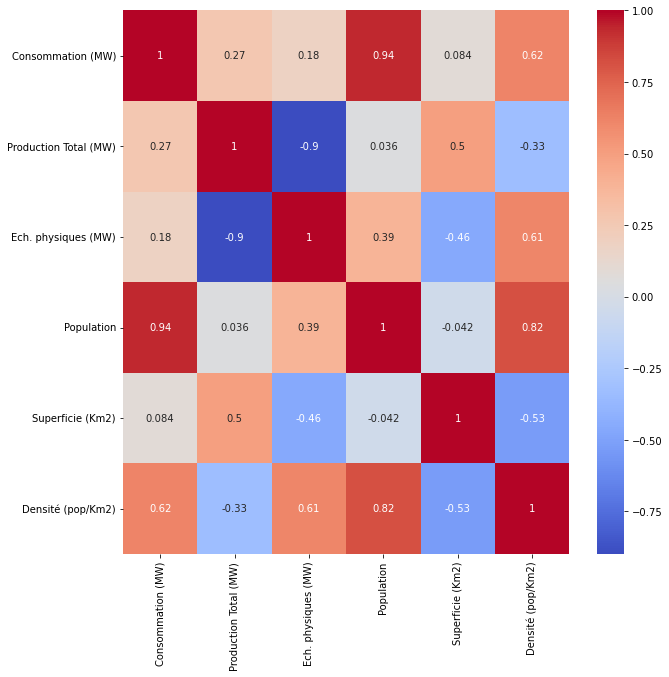

In [16]:
plt.figure(figsize=(10,10))
sns.heatmap(df_region.corr(), annot = True, cmap = 'coolwarm')

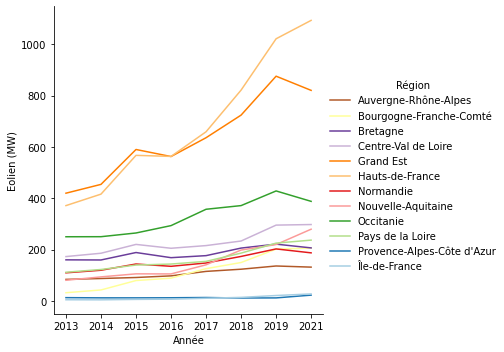

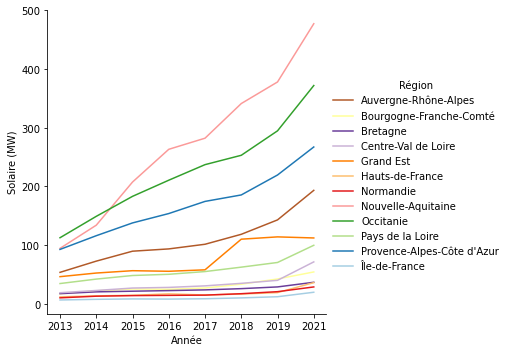

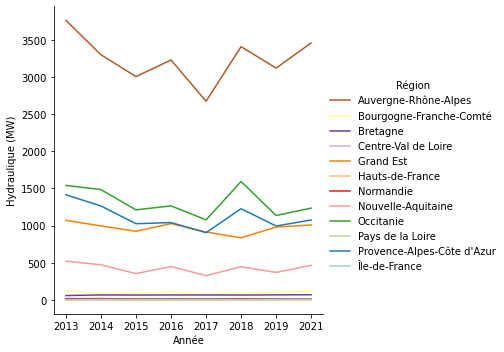

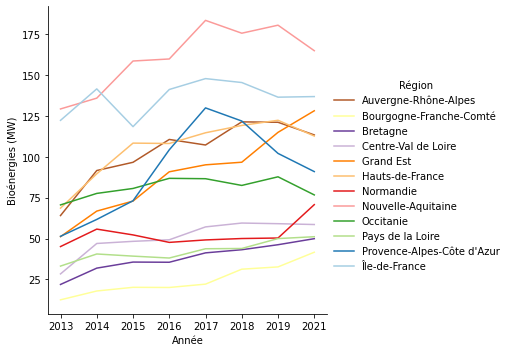

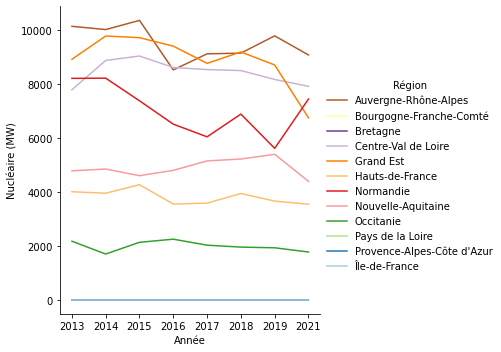

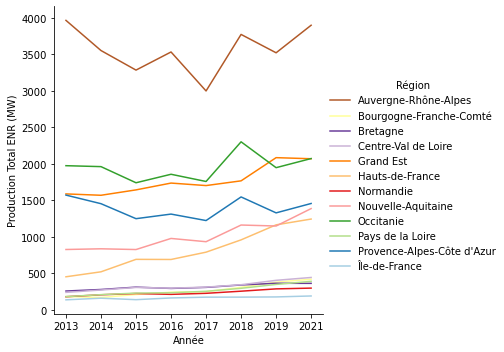

In [17]:
#Courbe pour chaque régions de la production d'enrgie renouvelables en France (5)
r = df.groupby(['Région', 'Année'], as_index = False).agg({'Eolien (MW)':'mean',
                                                           'Solaire (MW)' : 'mean',
                                                           'Hydraulique (MW)' : 'mean',
                                                           'Bioénergies (MW)' : 'mean',
                                                           'Nucléaire (MW)' : 'mean',
                                                           'Production Total ENR (MW)' : 'mean'})



sns.relplot(x = 'Année',
            y = 'Eolien (MW)',
            kind ='line',
            hue ='Région',
            palette='Paired_r',
            data =r)
sns.relplot(x = 'Année',
            y = 'Solaire (MW)',
            kind ='line',
            hue ='Région',
            palette='Paired_r',
            data =r)
sns.relplot(x = 'Année',
            y = 'Hydraulique (MW)',
            kind ='line',
            hue ='Région',
            palette='Paired_r',
            data =r)
sns.relplot(x = 'Année',
            y = 'Bioénergies (MW)',
            kind ='line',
            hue ='Région',
            palette='Paired_r',
            data =r)
sns.relplot(x = 'Année',
            y = 'Nucléaire (MW)',
            kind ='line',
            hue ='Région',
            palette='Paired_r',
            data =r)
sns.relplot(x = 'Année',
            y = 'Production Total ENR (MW)',
            kind ='line',
            hue ='Région',
            palette='Paired_r',
            data =r)


In [18]:
#Camembert sur la répartition des parts de la production des énergies renouvelables dans les régions française en 2019 : 

In [19]:
r = df.groupby(['Région', 'Année'], as_index = False).agg({'Eolien (MW)':'mean',
                                                           'Solaire (MW)' : 'mean',
                                                           'Hydraulique (MW)' : 'mean',
                                                           'Bioénergies (MW)' : 'mean'})
r_auv= r.loc[(r['Région'] == 'Auvergne-Rhône-Alpes') & (r['Année'] == '2019')]
liste = r_auv.values.tolist()[0]
labels = ["Eolien", "Solaire", "Hydraulique", "Bioénergie","Nucléaire" ]
# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=1, specs=[[{'type':'domain'}]])
fig.add_trace(go.Pie(labels=labels, values=liste[2:], name=" AUV-RA 2013"),
              1, 1)
# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")
fig.update_layout(
    title_text="Auvergne-Rhône-Alpes Année 2019, focus sur les ENR",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text=' ', x=0.50, y=0.5, font_size=20, showarrow=False)])
fig.show()

In [20]:
r = df.groupby(['Région', 'Année'], as_index = False).agg({'Eolien (MW)':'mean',
                                                           'Solaire (MW)' : 'mean',
                                                           'Hydraulique (MW)' : 'mean',
                                                           'Bioénergies (MW)' : 'mean'})
r_auv= r.loc[(r['Région'] == 'Grand Est') & (r['Année'] == '2019')]
liste = r_auv.values.tolist()[0]
labels = ["Eolien", "Solaire", "Hydraulique", "Bioénergie","Nucléaire" ]
# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=1, specs=[[{'type':'domain'}]])
fig.add_trace(go.Pie(labels=labels, values=liste[2:], name=" AUV-RA 2013"),
              1, 1)
# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")
fig.update_layout(
    title_text="Grand Est Année 2019, focus sur les ENR",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text=' ', x=0.50, y=0.5, font_size=20, showarrow=False)])
fig.show()

In [21]:
r = df.groupby(['Région', 'Année'], as_index = False).agg({'Eolien (MW)':'mean',
                                                           'Solaire (MW)' : 'mean',
                                                           'Hydraulique (MW)' : 'mean',
                                                           'Bioénergies (MW)' : 'mean'})
r_auv= r.loc[(r['Région'] == 'Nouvelle-Aquitaine') & (r['Année'] == '2019')]
liste = r_auv.values.tolist()[0]
labels = ["Eolien", "Solaire", "Hydraulique", "Bioénergie","Nucléaire" ]
# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=1, specs=[[{'type':'domain'}]])
fig.add_trace(go.Pie(labels=labels, values=liste[2:], name=" AUV-RA 2013"),
              1, 1)
# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")
fig.update_layout(
    title_text="Nouvelle-Aquitaine Année 2019, focus sur les ENR",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text=' ', x=0.50, y=0.5, font_size=20, showarrow=False)])
fig.show()

In [22]:
#Histogramme sur la répartion des productions d'énergies renouvelables en France depuis 2013
import numpy as np
r = df.groupby(['Année'], as_index = False).agg({'Eolien (MW)':'mean',
                                                 'Solaire (MW)' : 'mean',
                                                 'Hydraulique (MW)' : 'mean',
                                                 'Bioénergies (MW)' : 'mean',
                                                 'Nucléaire (MW)' : 'mean',
                                                 'Consommation (MW)' : 'mean',
                                                  'Nucléaire (MW)' : 'mean'})
color = ['#B0AFE4','#ABD4E3','#AFE4CD','#E0BFA3','#DADF9F','#A8DF9F']
liste = ['Eolien (MW)','Solaire (MW)', 'Hydraulique (MW)','Bioénergies (MW)','Consommation (MW)']
for i,j in zip(liste,color):

  fig = go.Figure()
  fig.add_trace(go.Bar(
                      x=r['Année'],
                      y=r[i],
                      name=i,
                      marker_color= j ))
  fig.update_layout(title_text= 'prod ' + i + ' par an' )

  fig.update_layout(barmode='group', xaxis_tickangle=-45)
  fig.show()





## `Elaboration modèle`

In [23]:
import statsmodels.api as sm
import warnings
import statsmodels.formula.api as smf
warnings.filterwarnings('ignore')

In [24]:
#Création d'un dataframe conso_france qui montre la moyenne nationale de consommation en MW par mois depuis 2013
df_conso_france = df.groupby(['Date']).agg({'Consommation (MW)' : 'mean'})
df_conso_france = df_conso_france['Consommation (MW)']['2013':'2019'].resample('M').mean()
df_conso_france = pd.DataFrame(df_conso_france)
df_conso_france

Consommation (MW)
Date                         
2013-01-31        5967.547058
2013-02-28        6115.861979
2013-03-31        5516.056788
2013-04-30        4645.860880
2013-05-31        4106.993280
...                       ...
2019-08-31        3507.991711
2019-09-30        3705.140625
2019-10-31        4046.873768
2019-11-30        5056.755208
2019-12-31        5229.749664

[84 rows x 1 columns]

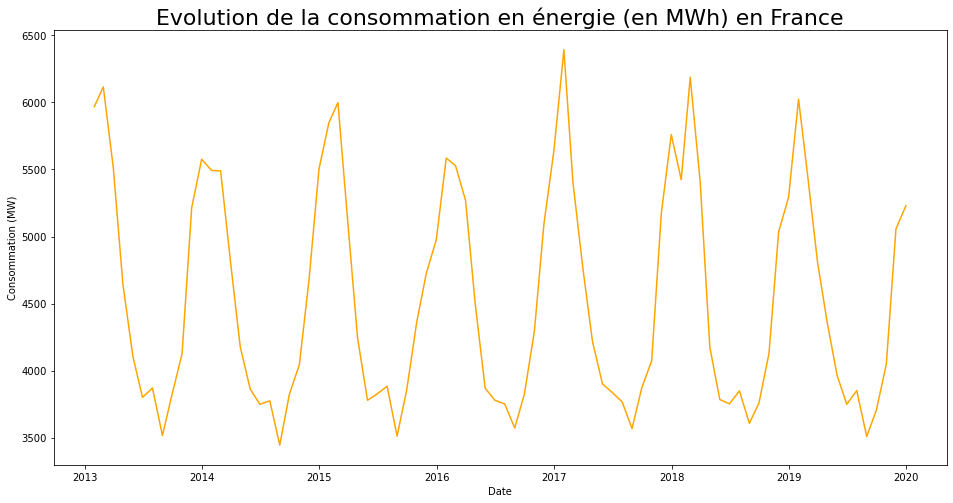

In [25]:
fig = plt.figure(figsize=(16,8))
sns.lineplot(data=df_conso_france, x=df_conso_france.index,  y="Consommation (MW)", color="orange")
plt.title("Evolution de la consommation en énergie (en MWh) en France", fontsize=22)
plt.show()

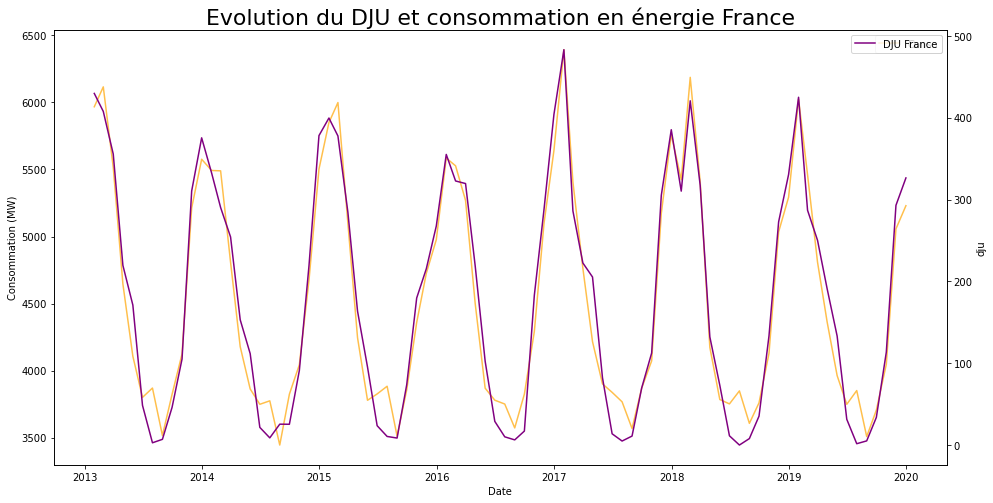

In [26]:
fig = plt.figure(figsize=(16,8))
ax1 = sns.lineplot(data=df_conso_france, x=df_conso_france.index,  y="Consommation (MW)", color="orange", alpha=0.7, legend='brief', label="Conso")
ax2 = plt.twinx()
ax2 = sns.lineplot(data=df_dju_france, x=df_dju_france.index,  y="dju", color="purple", ax=ax2, legend='brief', label="DJU France")
plt.legend()
plt.title("Evolution du DJU et consommation en énergie France", fontsize=22)
plt.show()

In [27]:
#On créé notre base de donnée en regroupant les 2 dataframe qui nous intéresse
datas = pd.merge(df_dju_france, df_conso_france.reset_index().rename(columns={"Date":"Periode"}), on="Periode", how="left").set_index("Periode")
datas = datas.rename(columns = {"Consommation (MW)":"Conso"})
datas.head()

dju        Conso
Periode                            
2013-01-31  429.558333  5967.547058
2013-02-28  407.600000  6115.861979
2013-03-31  355.508333  5516.056788
2013-04-30  219.616667  4645.860880
2013-05-31  171.125000  4106.993280

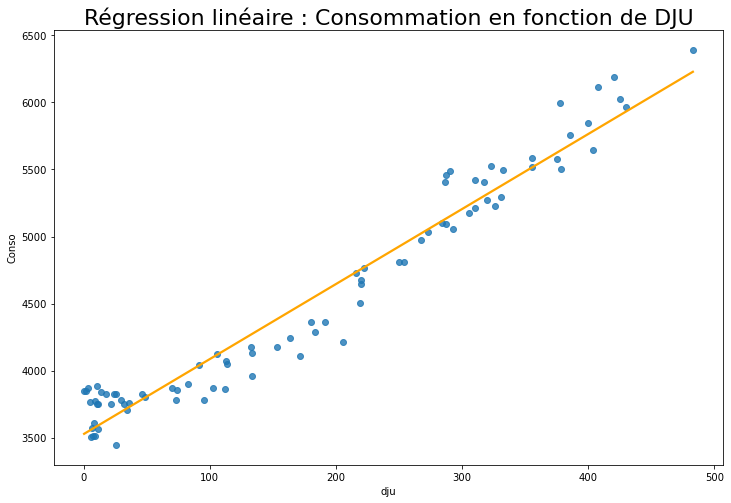

In [28]:
fig = plt.figure(figsize=(12,8))
ax = sns.regplot(data=datas, x="dju", y="Conso", robust=True, ci=None, line_kws={"color":"orange"})
plt.title("Régression linéaire : Consommation en fonction de DJU", fontsize=22)
plt.show()

In [29]:
#régression linéaire simple grâce à la librairie Statsmodels et recherche des parametres a et b 
reg_conso = smf.ols('Conso ~ dju', data=datas).fit()
print(reg_conso.summary())

# Les cofficients de regressions a et b sont :
a, b = reg_conso.params
print("a =",a,"| b =",b)

                            OLS Regression Results                            
Dep. Variable:                  Conso   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     1618.
Date:                Tue, 26 Apr 2022   Prob (F-statistic):           9.42e-56
Time:                        22:17:48   Log-Likelihood:                -555.48
No. Observations:                  84   AIC:                             1115.
Df Residuals:                      82   BIC:                             1120.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3526.4586     31.984    110.256      0.0

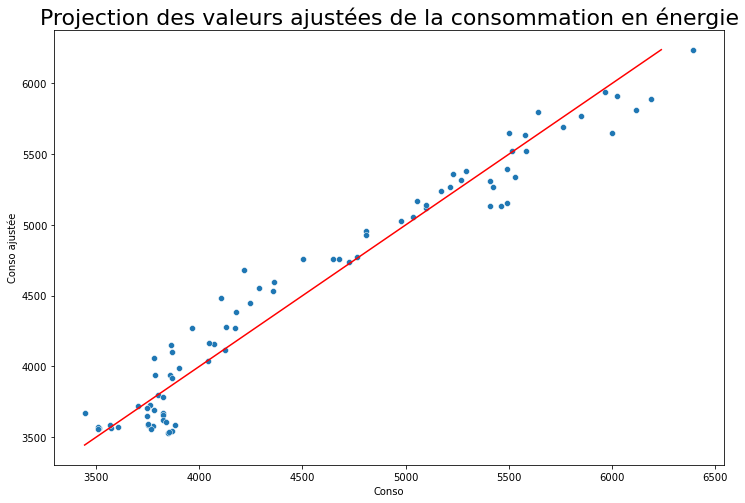

In [30]:
datas['Conso_ajuste'] = reg_conso.predict()

X_plot = [datas['Conso'].min(), datas['Conso_ajuste'].max()]

fig = plt.figure(figsize=(12,8))
ax = sns.scatterplot(x="Conso", y="Conso_ajuste", data=datas)
ax.set(xlabel='Conso', ylabel='Conso ajustée')
plt.plot(X_plot, X_plot, color='r')
plt.title("Projection des valeurs ajustées de la consommation en énergie", fontsize=22)
plt.show()

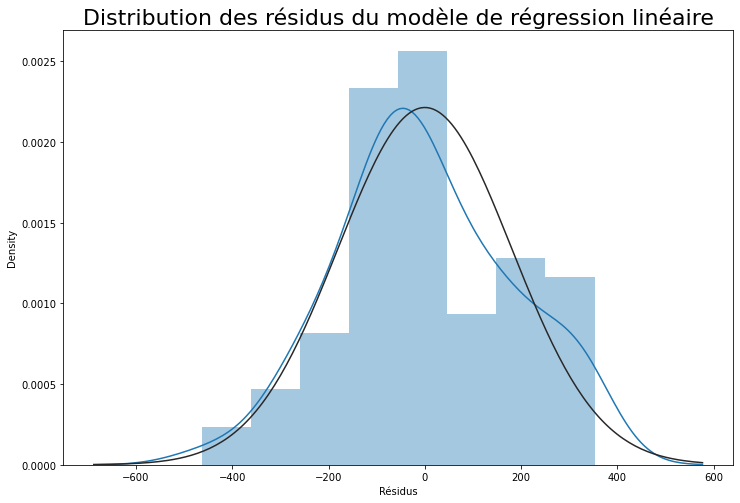

In [31]:
from scipy.stats import norm, shapiro

fig = plt.figure(figsize=(12,8))
ax = sns.distplot(reg_conso.resid, fit=norm)
plt.xlabel('Résidus')
plt.title("Distribution des résidus du modèle de régression linéaire", fontsize=22)
plt.show()

In [32]:
shapiro_test = shapiro(reg_conso.resid)
shapiro_test

ShapiroResult(statistic=0.9808792471885681, pvalue=0.24650976061820984)

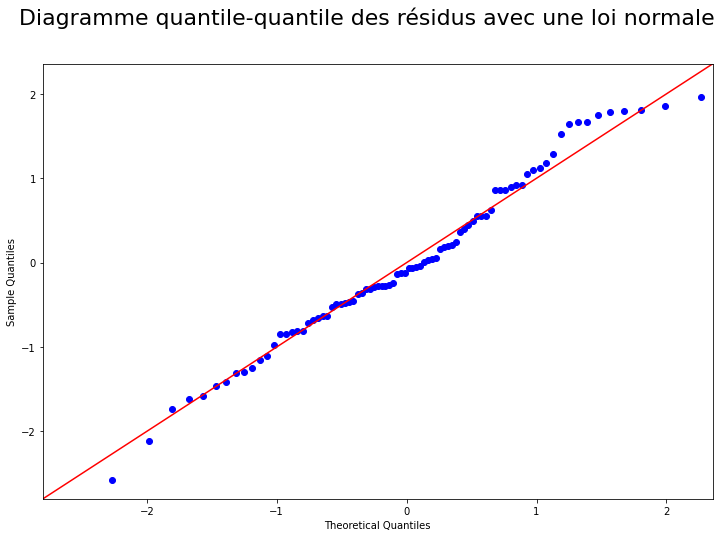

In [33]:
fig = sm.qqplot(reg_conso.resid, fit=True, line="45")
fig.set_size_inches(12, 8)
fig.suptitle("Diagramme quantile-quantile des résidus avec une loi normale", fontsize=22)
plt.show()


In [34]:
# Calcul des données de consommation ajustées des effets de température
datas['Conso_ajuste'] = datas['Conso'] - (datas['dju']*b)

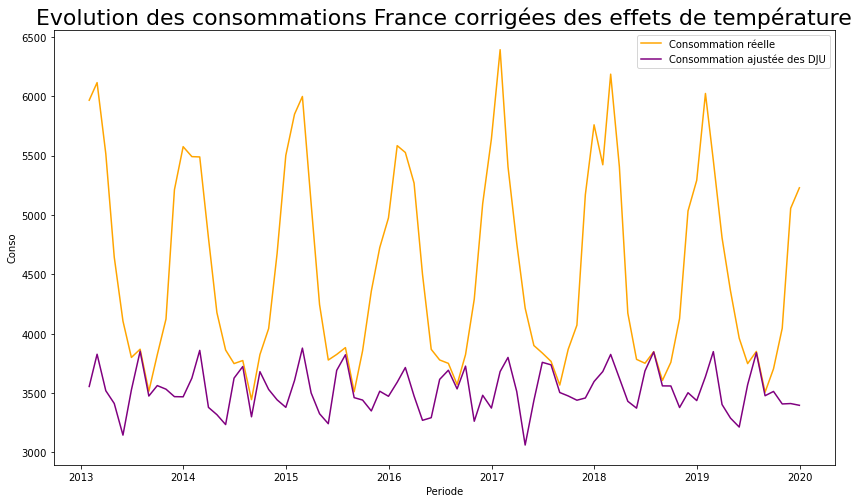

In [35]:
fig = plt.figure(figsize=(14,8))
ax1 = sns.lineplot(data=datas, x=datas.index,  y="Conso", color="orange", legend='brief', label="Consommation réelle")
ax2 = sns.lineplot(data=datas, x=datas.index,  y="Conso_ajuste", color="purple", legend='brief', label="Consommation ajustée des DJU")
plt.title("Evolution des consommations France corrigées des effets de température", fontsize=22)
plt.show()

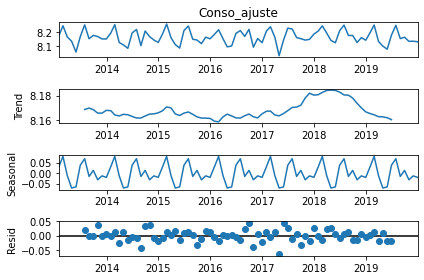

In [36]:
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
x = datas["Conso_ajuste"]
y = np.log(x)
decomp_y = seasonal_decompose(y,  model='additive')
decomp_y.plot()
plt.show()

In [37]:
#Base de données des valeurs ajustées et des données corrigées des variations saisonnières (CVS)
df_decomp_y_seasonal = pd.DataFrame(decomp_y.seasonal)
y_compl = pd.merge(y, df_decomp_y_seasonal, on="Periode")
y_compl["cvs"] = np.exp(y_compl["Conso_ajuste"] - y_compl["seasonal"])
y_compl


Conso_ajuste  seasonal          cvs
Periode                                        
2013-01-31      8.176388  0.031116  3447.045575
2013-02-28      8.249988  0.080425  3531.800391
2013-03-31      8.166278 -0.012325  3563.874888
2013-04-30      8.135325 -0.071535  3666.011021
2013-05-31      8.053979 -0.065972  3360.857659
...                  ...       ...          ...
2019-08-31      8.154241 -0.015899  3533.838617
2019-09-30      8.164585  0.013028  3468.777109
2019-10-31      8.134140 -0.031945  3519.539767
2019-11-30      8.135117 -0.013206  3457.576848
2019-12-31      8.130785 -0.020500  3467.834618

[84 rows x 3 columns]

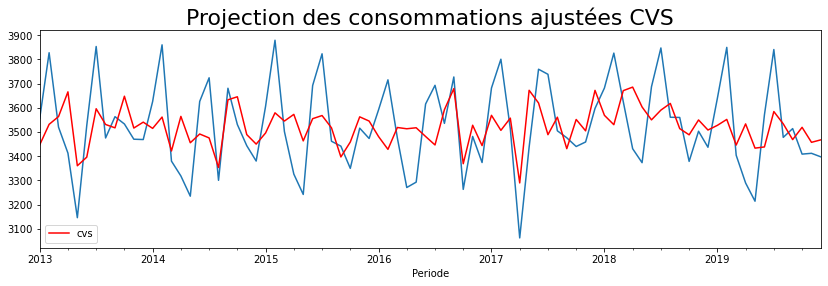

In [38]:
x.plot(figsize=(14,4))
#Plot des valeurs obtenues par CVS des moyennes mobiles
y_compl["cvs"].plot(legend = True, color="r")
plt.title("Projection des consommations ajustées CVS", fontsize=22)
plt.show()

In [39]:
#Proévision HOLT-Winters

In [40]:
#Test/Train split
x_train = x["2013":"2018"]
x_test = x["2019"]
y_train = np.log(x_train)
y_test = np.log(x_test)

from statsmodels.tsa.api import ExponentialSmoothing
hw_ln = ExponentialSmoothing(np.asarray(y_train), seasonal_periods=12, trend='add', seasonal='add').fit()
hw_pred_ln = hw_ln.forecast(12)

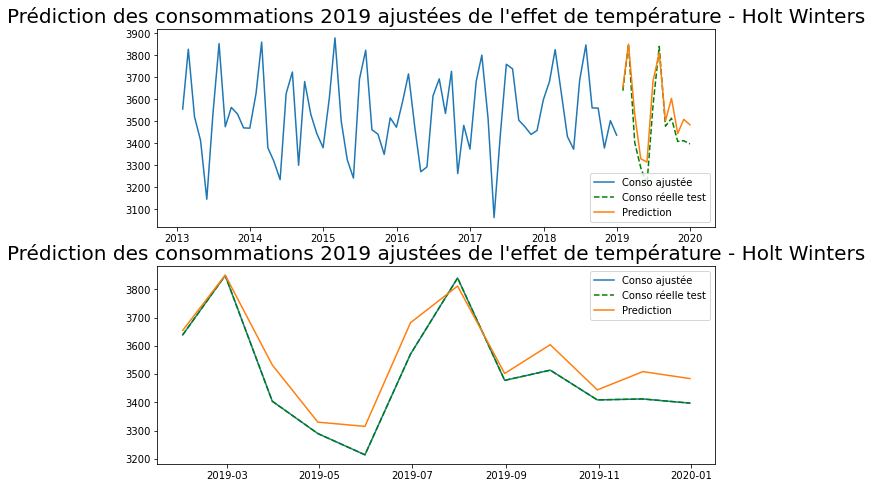

In [41]:
plt.figure(figsize=(10,8))
plt.subplot(211)
plt.plot(x_train, label='Conso ajustée')
plt.plot(x_test, label='Conso réelle test', color="g", linestyle="--")
plt.plot(y_test.index, np.exp(hw_pred_ln), label='Prediction')
plt.title("Prédiction des consommations 2019 ajustées de l'effet de température - Holt Winters", fontsize=20)
plt.legend()

#Zoom
plt.subplot(212)
plt.plot(x["2019":], label='Conso ajustée')
plt.plot(x_test, label='Conso réelle test', color="g", linestyle="--")
plt.plot(y_test.index, np.exp(hw_pred_ln), label='Prediction')
plt.title("Prédiction des consommations 2019 ajustées de l'effet de température - Holt Winters", fontsize=20)
plt.legend()

plt.show()


In [42]:
##Methode SARIMA

In [43]:
from statsmodels.tsa.stattools import adfuller, acf, pacf
#ADF-test(Série originelle)
res_adf_o = adfuller(x,regression='ct')
print('p-value ADF série originelle :{}'.format(res_adf_o[1]))

#ADF-test(Série différenciée)
res_adf_d = adfuller(x.diff().dropna(),regression='c')
print('p-value ADF série différenciée :{}'.format(res_adf_d[1]))

p-value ADF série originelle :0.49446144898449335
p-value ADF série différenciée :0.00036065069437073296


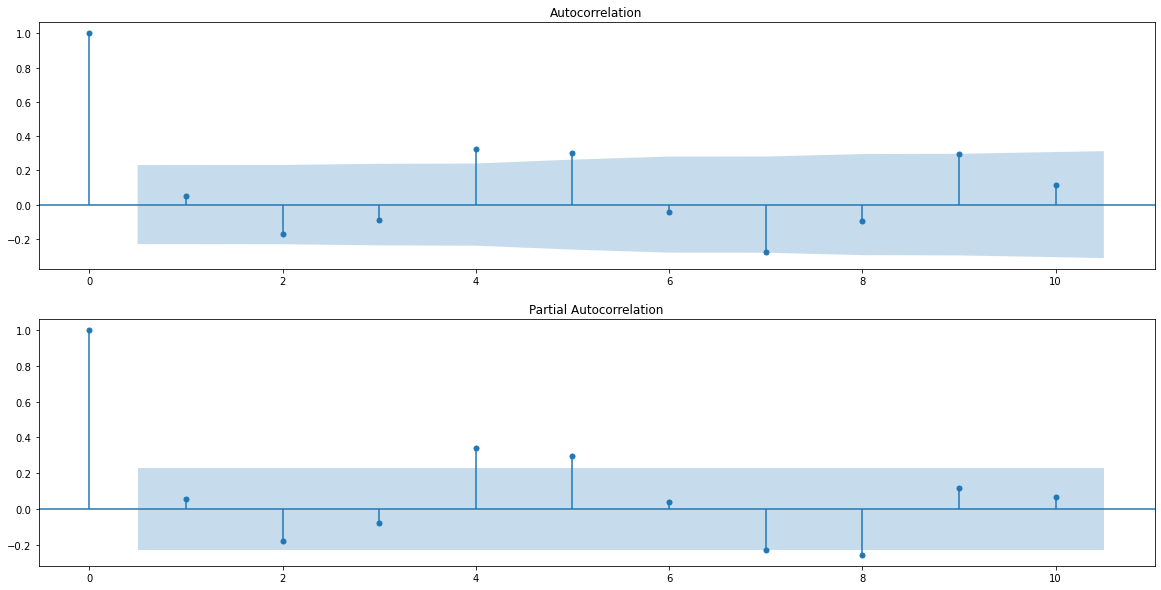

In [44]:
# Projection de l' autocorrélogramme d'ordre 12
y_diff_12 = y.diff(12)
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(y_diff_12.dropna(), lags=10, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(y_diff_12.dropna(), lags=10, ax=ax[1])
plt.show()

In [45]:
from statsmodels.tsa.statespace.sarimax import *
from statsmodels.stats.diagnostic import acorr_ljungbox

#Estimation et validation des modèles SARIMA
model1 = SARIMAX(np.asarray(y), order=(1,0,1), seasonal_order=(1,0,1,12))
results1 = model1.fit()
residus1 = results1.resid
print(results1.summary())


print('\nTEST DE JUNG-BOX - (Test de blancheur)\n\nRetard : p-value')
for elt in np.arange(6,50,6):
    print('{} : {}'.format(elt, acorr_ljungbox(results1.resid, lags=elt)[1].mean()))


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   84
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 135.589
Date:                            Tue, 26 Apr 2022   AIC                           -261.178
Time:                                    22:17:54   BIC                           -249.024
Sample:                                         0   HQIC                          -256.292
                                             - 84                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999   8.89e-05   1.13e+04      0.000       1.000       1.000
ma.L1         -0.1747      0.000  -

matplotlib.figure.Figure

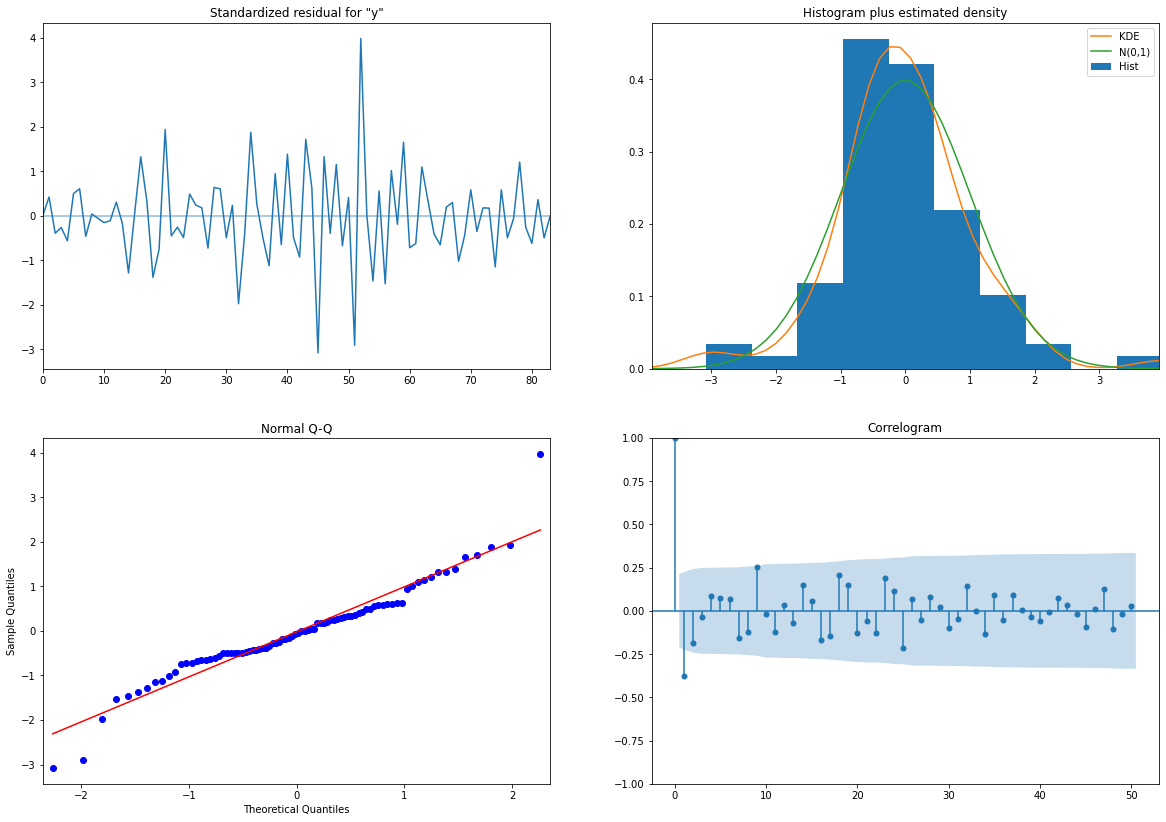

In [46]:
def plot_diagnostics(sarima_res, variable=0, lags=10, fig=None, figsize=None):
        return type(sarima_res.plot_diagnostics(variable, lags, fig, figsize))
plot_diagnostics(sarima_res = results1, figsize=(20,14), lags=50) 

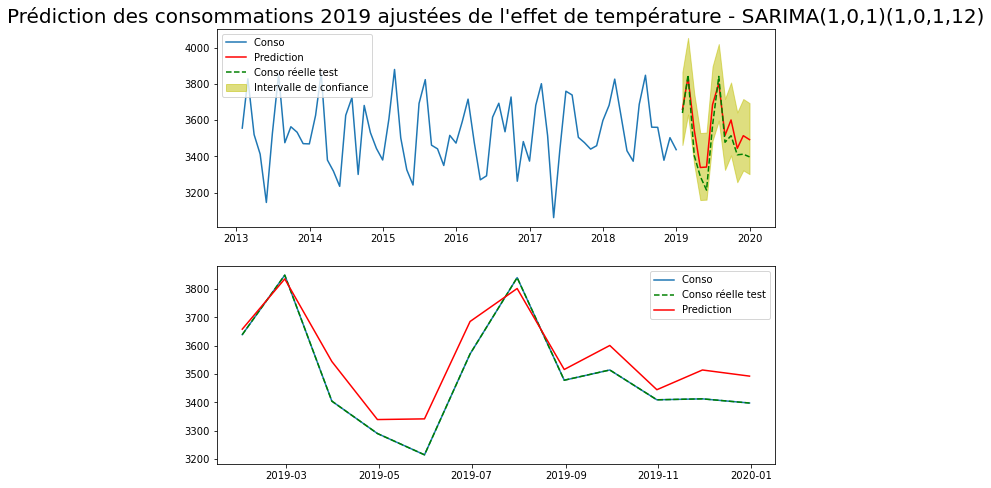

In [47]:
model_train = SARIMAX(np.asarray(y_train), order=(1,0,1), seasonal_order=(1,0,1,12))
results_train = model_train.fit()
pred_model = results_train.get_forecast(12)
pred = pred_model.predicted_mean

#Intervals de prévisions à 5%
pred_ci = pred_model.conf_int(alpha=0.05)

plt.figure(figsize=(10,8))
plt.subplot(211)
plt.plot(x_train, label='Conso ')
plt.plot(y_test.index, np.exp(pred), color='r', label='Prediction')
plt.plot(np.exp(y_test), label='Conso réelle test', color="g", linestyle="--")
plt.fill_between(y_test.index, np.exp(pred_ci[:,0]), np.exp(pred_ci[:,1]), alpha=0.5, color="y", label="Intervalle de confiance")
plt.title("Prédiction des consommations 2019 ajustées de l'effet de température - SARIMA(1,0,1)(1,0,1,12)", fontsize=20)
plt.legend()

#Zoom
plt.subplot(212)
plt.plot(x["2019":], label='Conso ')
plt.plot(x_test, label='Conso réelle test', color="g", linestyle="--")
plt.plot(y_test.index, np.exp(pred), color='r', label='Prediction')
plt.legend()

plt.show()

In [48]:
#Fonction pour calcul de différentes métriques 
def metrics_timeseries(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    diff = y_true - y_pred
    mae = np.mean(abs(diff))
    mse = np.mean(diff**2)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs(diff / y_true)) * 100
    r2 = 1-(sum(diff**2)/sum((y_true-np.mean(y_true))**2))
    dict_metrics = {"Métrique":["MAE", "MSE", "RMSE", "MAPE", "R²"], "Résultats":[mae, mse, rmse, mape, r2]}
    df_metrics = pd.DataFrame(dict_metrics)
    return df_metrics


In [49]:
df_metrics_holt_winters = metrics_timeseries(np.exp(y_test), np.exp(hw_pred_ln))
df_metrics_SARIMA = metrics_timeseries(np.exp(y_test), np.exp(pred))
df_compare_metrics = pd.merge(df_metrics_holt_winters, df_metrics_SARIMA, on="Métrique").rename(columns={"Résultats_x":"Résultats HW","Résultats_y":"Résultats SARIMA"})
df_compare_metrics

Métrique  Résultats HW  Résultats SARIMA
0      MAE     63.397222         71.659767
1      MSE   5724.915798       6923.501614
2     RMSE     75.663173         83.207581
3     MAPE      1.848321          2.088068
4       R²      0.838345          0.804501

In [50]:
#Prédiction ajustéespour 2020

In [51]:
hw_ln_2020 = ExponentialSmoothing(np.asarray(y), seasonal_periods=12, trend='add', seasonal='add').fit()
hw_pred_ln_2020 = hw_ln_2020.forecast(12)


In [52]:
pred_model_2020 = results1.get_forecast(12)
pred_2020 = pred_model_2020.predicted_mean
#Intervals de prévisions à 5%
pred_ci_2020 = pred_model_2020.conf_int(alpha=0.05)


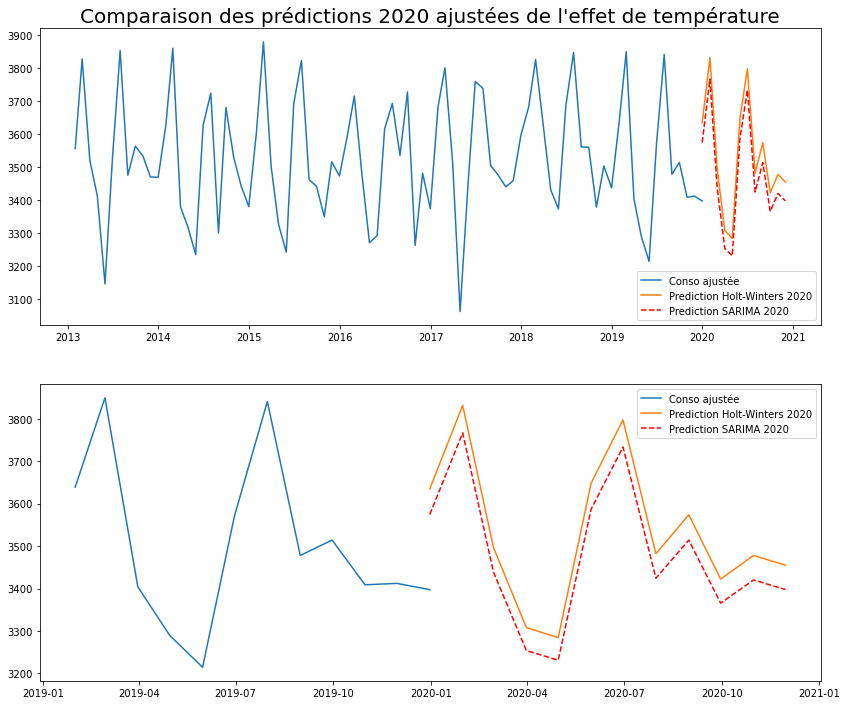

In [53]:
plt.figure(figsize=(14,12))
plt.subplot(211)
plt.plot(x, label='Conso ajustée')
plt.plot(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), np.exp(hw_pred_ln_2020), label='Prediction Holt-Winters 2020')
plt.plot(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), np.exp(pred_2020), color='r', linestyle="--", label='Prediction SARIMA 2020')
plt.title("Comparaison des prédictions 2020 ajustées de l'effet de température", fontsize=20)
plt.legend()

#Zoom
plt.subplot(212)
plt.plot(x["2019":], label='Conso ajustée')
plt.plot(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), np.exp(hw_pred_ln_2020), label='Prediction Holt-Winters 2020')
plt.plot(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), np.exp(pred_2020), color='r', linestyle="--", label='Prediction SARIMA 2020')
plt.legend()

plt.show()

In [54]:
#Modélisaition régression linéaire DJU/consommation 

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate

In [56]:
datas.corr()

dju     Conso  Conso_ajuste
dju           1.000000e+00  0.975582  2.355647e-15
Conso         9.755818e-01  1.000000  2.196363e-01
Conso_ajuste  2.355647e-15  0.219636  1.000000e+00

In [57]:
#Train/Test split
x = datas[["dju"]]
y = datas[["Conso"]]

In [58]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=42)

In [59]:
#Entrainemnt du modèle de régression linéaire
reg = LinearRegression()
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)

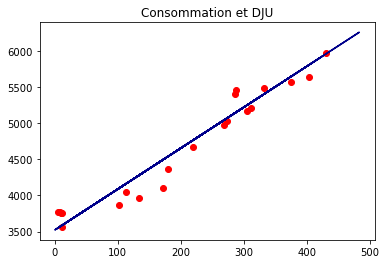

In [60]:
plt.scatter(x_test, y_test, color = 'red')
plt.plot(x_train, reg.predict(x_train), color = "darkblue")
plt.title("Consommation et DJU")
plt.show()

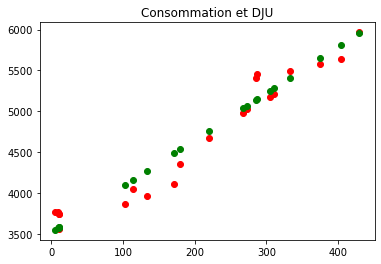

In [61]:
plt.scatter(x_test, y_test, color = 'red')
plt.scatter(x_test, y_pred, color = 'green')
plt.title("Consommation et DJU")
plt.show()

In [62]:
#Fonction qui transforme la moyenne de degrés du mois placé en parmatres en DJU du mois 
#Ici par exemple on prend un mois de Janvier dont la tempréture moyenne est de 5,8 , le DJU du mois est de 378,2
liste31 = ['Janvier','Mars','Mai','Juillet','Aout','Octobre','Decembre']
liste30 = ['Avril','Juin','Septempbre','Novembre']

def degres_à_dju(degrés, mois):
    n = 18 - degrés
    for i in liste31:
        if mois == i :
            dju = n * 31
    for i in liste30:
        if mois == i:
            dju = n * 30
    if mois == 'Fevrier':
        dju = n * 28
    
    return dju
degres_à_dju(5.8, 'Janvier')

378.2

In [63]:
#On test ainsi la commation moyenne par mois pour un DJU de 378.2
reg = reg.fit(x,y)
reg.predict(np.array(degres_à_dju(5.8, 'Janvier')).reshape(1,-1))


array([[5649.68912156]])

In [64]:
#Métrique de régression linéaire R2 et validation croisée
print("Coefficient de détermination R2 du modèle d'entrinement :", reg.score(x_train, y_train))
print("Coefficient de détermination obtenu par Cv d'entrainement :", cross_val_score(reg,x_train,y_train).mean())
print('Coefficient de détermination R2 du modèle de test:', reg.score(x_test, y_test))
print('Coefficient de détermination obtenu par Cv :', cross_val_score(reg,x_test,y_test).mean())


Coefficient de détermination R2 du modèle d'entrinement : 0.9538938727294923
Coefficient de détermination obtenu par Cv d'entrainement : 0.9241097422744085
Coefficient de détermination R2 du modèle de test: 0.9429477167609863
Coefficient de détermination obtenu par Cv : 0.8506940412787098


In [65]:
#Modélisaition régression linéaire Population/consommation 

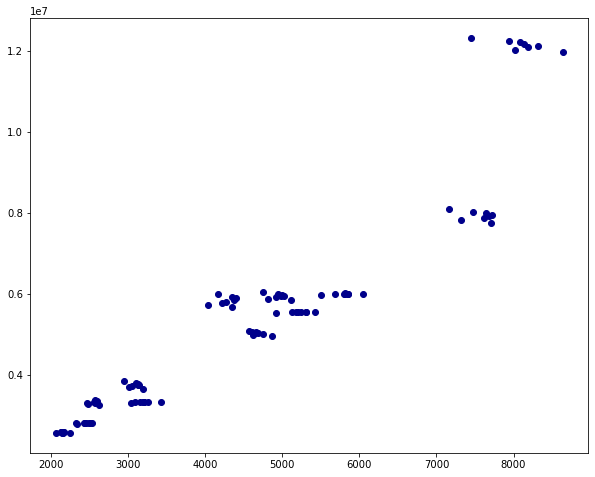

In [66]:
plt.figure(figsize=(10, 8))

plt.scatter(df_region['Consommation (MW)'], df_region['Population'], color='darkblue');

In [67]:
df_region_ml = df_region

df_region_ml.drop(["Région","Année","Production Total (MW)","Superficie (Km2)","Densité (pop/Km2)"], axis = 1, inplace = True) 

In [68]:
x = df_region_ml[["Population"]]
y = df_region_ml[["Consommation (MW)"]]

In [69]:
#Train/Test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=42)
reg = LinearRegression()
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)

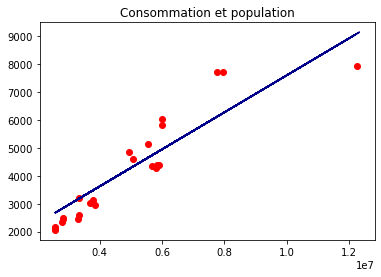

In [70]:
#Viz prediction 
plt.scatter(x_test, y_test, color = 'red')
plt.plot(x_train, reg.predict(x_train), color = "darkblue")
plt.title("Consommation et population")
plt.show()

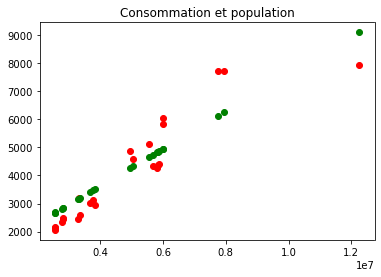

In [71]:
#viz pred
plt.scatter(x_test, y_test, color = 'red')
plt.scatter(x_test, y_pred, color = 'green')
plt.title("Consommation et population")
plt.show()

In [72]:
#test valeur, à combien estimer la consommation moyenne annuelle pour une population de 9 000 000 dans une région
import numpy as np
reg = reg.fit(x,y)
reg.predict(np.array(7000000).reshape(1,-1))

array([[5624.78610441]])

In [73]:
print("Coefficient de détermination du modèle d'entrinement :", reg.score(x_train, y_train))
print("Coefficient de détermination obtenu par Cv d'entrainement :", cross_val_score(reg,x_train,y_train).mean())
print('Coefficient de détermination du modèle de test:', reg.score(x_test, y_test))
print('Coefficient de détermination obtenu par Cv :', cross_val_score(reg,x_test,y_test).mean())

Coefficient de détermination du modèle d'entrinement : 0.8795738831029518
Coefficient de détermination obtenu par Cv d'entrainement : 0.8419353522525649
Coefficient de détermination du modèle de test: 0.8490592040629822
Coefficient de détermination obtenu par Cv : 0.7058724921693973
